In [2]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
from chainer import cuda
import cupy
from IPython import display
from data_utils import load_data, normalize, to_variable
import models, nn, graph_ops

In [3]:
'''
Set array backend, seed
'''
def seed_rng(s):
    xp.random.seed(s)
    np.random.seed(s)
rng_seed = 98765
use_gpu = True
xp = cupy if use_gpu >= 0 else np
print('xp: {}'.format(xp))
print('rng_seed = {} '.format(rng_seed))

xp: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
rng_seed = 98765 


In [4]:
def next_minibatch(in_list,batch_size):
    if all(len(i) == len(in_list[0]) for i in in_list) == False:   
        raise ValueError('Inputs do not have the same dimension')
    index_list = np.random.permutation(len(in_list[0]))[:batch_size]#np.random.randint(len(in_list[0]), size=batch_size)
    out = list()
    rands = np.random.rand(6)
    shift = np.random.rand(batch_size,3)
    for k in range(len(in_list)):
        tmp = in_list[k][index_list]
        if rands[0] < .5:
            tmp = tmp[:,:,[1,0,2,4,3,5]]
        if rands[1] < .5:
            tmp = tmp[:,:, [0,2,1,3,5,4]]
        if rands[2] < .5:
            tmp = tmp[:,:, [2,1,0,5,4,3]]
        if rands[3] < .5:
            tmp[:,:,0] = 1 - tmp[:,:,0]
            tmp[:,:,3] = -tmp[:,:,3]
        if rands[4] < .5:
            tmp[:,:,1] = 1 - tmp[:,:,1]
            tmp[:,:,4] = -tmp[:,:,4]
        if rands[5] < .5:
            tmp[:,:,2] = 1 - tmp[:,:,2]
            tmp[:,:,5] = -tmp[:,:,5]
            
        tmploc = tmp[:,:,:3]
        tmploc += shift[:,None,:]
        gt1 = tmploc > 1
        tmploc[gt1] = tmploc[gt1] - 1
        tmp[:,:,:3] = tmploc
        out.append(tmp)
    return out

In [ ]:
'''
Hyperparameter search
'''
from IPython.display import clear_output
from prettytable import PrettyTable

num_particles = 16 # defaults 16**3
lr = 0.01
mb_size = 8
n_iterations = 1000
"""
chan_vals = [2**i for i in range(3,9)]
chan_depth = [i for i in range(2,15)]
channels = [list(np.random.choice(chan_vals, np.random.choice(chan_depth))) for i in range(1000)]
for chn in channels:
    chn.insert(0, 6)
    chn.append(3)
channels.insert(0, [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3])
"""

#bounds = [0.0, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
#redshifts = [(0.4, 0.0), (0.8, 0.0), (6.0, 1.2), (4.0, 2.0), (0.8, 0.6), (1.5, 1.0), (1.2, 0.2), (6.0, 0.4)]
#n_NN = list(np.arange(8,31))
#n_NN.insert(0,0)
#rads = [0.0095, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001]
channels = np.load('pruned_chans.npy')
redshifts = [(0.4, 0.0), (6.0, 0.0), (4.0, 0.6), (0.8, 0.2), (1.0, 0.4), (2.0, 0.8), (1.2, 0.6), (2.0, 1.5), (0.4, 0.2)]
search_params = channels
param_label = "chans"

def pprint_avgs(arr):
    #lst = [list(row) for row in list(arr)]
    lst = [['%0.7f'%elem for elem in row] for row in arr]
    ptab = PrettyTable()
    ptab.field_names = [param_label] + [str(rs) for rs in redshifts]
    for idx, row in enumerate(lst):
        param = search_params[idx]
        ptab.add_row([idx] + row)
    print(ptab)

#specs = [('knn', 9),('knn', 11),('knn', 13),('knn', 15),('knn', 17),('knn', 21),('knn', 23),('knn', 25),('knn', 27), ]
loss_history = np.zeros((n_iterations,len(search_params),len(redshifts)), dtype=np.float32)
#loss_avgs = np.zeros((len(search_params), len(redshifts)))
loss_avgs = np.load('pruned_lm.npy')
iters_count = 0
for rs_idx, rs in enumerate(redshifts):
    if rs in [(0.4, 0.0), (6.0, 0.0)]: continue
    zX, zY = rs
    _X,_Y = load_data(zX, zY, num_particles)
    for p_idx, PARAM in enumerate(search_params):
        # MUST SEED BEFORE EACH TRAINING SESSION
        seed_rng(rng_seed) # insure that every model begins with same
        zX, zY = rs
        _X,_Y = load_data(zX, zY, num_particles)
        X,Y = np.copy(_X), np.copy(_Y)
        X = normalize(X)
        Y = normalize(Y)
        #chan = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3]
        #use_graph = False if PARAM == 0 else True
        use_graph = False
        model = models.nBodyModel(PARAM, use_graph=use_graph)
        model.to_gpu()
        optimizer = optimizers.Adam(alpha=lr)
        optimizer.setup(model)
        seed_rng(rng_seed) # insure that every model begins with same
        
        cur_settings = [PARAM, rs]
        print('param: {}, zX, zY: {}'.format(PARAM, (zX,zY)))
        for tr_iter in range(1, n_iterations +1):
            model.zerograds()
            # data
            _x_in_, _x_true_ = next_minibatch([X,Y], mb_size)
            _x_in, _x_true = np.copy(_x_in_), np.copy(_x_true_)
            x_in = chainer.Variable(cuda.to_gpu(_x_in.astype(xp.float32)))
            x_true = chainer.Variable(cuda.to_gpu(_x_true.astype(xp.float32)))
            # forward
            if not use_graph:
                graphNN = None
            else:
                graphNN = graph_ops.GraphNN(_x_in, 'rad', PARAM)
                #assert graphNN.graph.alist.shape[-1] == PARAM
            x_hat = model(x_in, graphNN=graphNN, add=True, bounded=True) # prediction
            loss = nn.loss_fun_bounded(x_hat, x_true, 0.095)
            # backprop
            loss.backward()
            optimizer.update()
            loss_history[tr_iter-1, p_idx, rs_idx] = cuda.to_cpu(loss.data)
        iters_count += 1
        endloss = np.median(loss_history[-100:, p_idx, rs_idx])
        loss_avgs[p_idx, rs_idx] = endloss
        rsf = (endloss, cur_settings)
        clear_output(wait=True)
        pprint_avgs(loss_avgs)
    np.save('PRUNED_LOSSAVG', loss_avgs)
           
'''
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| bounds |     (0.4, 0.0)    |     (0.8, 0.0)    |     (6.0, 1.2)    |     (4.0, 2.0)    |     (0.8, 0.6)    |     (1.5, 1.0)    |     (1.2, 0.2)    |
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  0.0   | 0.000119890377391 | 0.000457710237242 | 0.000162970478414 | 1.83323718375e-05 | 3.16315745295e-05 | 3.01272466459e-05 | 0.000394351867726 |
|  0.1   | 0.000115659378935 | 0.000500292750075 | 0.000203645016882 | 1.69450759131e-05 | 9.24624055187e-06 |  2.8423832191e-05 | 0.000487153010909 |
|  0.09  | 0.000115799157356 | 0.000559969630558 |  0.00023882460664 | 1.74512952071e-05 | 9.26273605728e-06 | 2.84684101644e-05 | 0.000572036020458 |
|  0.08  | 0.000116949391668 | 0.000655652140267 | 0.000299750536215 | 1.96377641259e-05 | 9.30869464355e-06 | 2.90543866868e-05 | 0.000710388296284 |
|  0.07  | 0.000120661708934 |  0.00084223295562 | 0.000426335580414 | 2.46218041866e-05 | 9.20692764339e-06 | 3.07395057462e-05 | 0.000908661459107 |
|  0.06  | 0.000139344963827 |  0.00122337543871 | 0.000728332379367 | 3.16597470373e-05 | 9.24199503061e-06 | 3.68279579561e-05 |  0.00116449513007 |
|  0.05  | 0.000196880107978 |  0.00139848690014 |  0.00132458866574 | 4.45803343609e-05 | 3.16621590173e-05 | 5.26102048752e-05 |  0.0013643016573  |
|  0.04  | 0.000389787834138 |  0.00283175101504 |  0.00187213870231 | 6.82938407408e-05 | 3.19446407957e-05 | 9.32425173232e-05 |  0.00223632133566 |
|  0.03  |  0.00107194168959 |  0.00341849774122 |  0.00439322041348 | 0.000150620136992 | 3.74845330953e-05 | 0.000194006090169 |  0.00389076955616 |
|  0.01  |  0.00541484635323 |  0.0116537790745  |  0.00976342987269 |  0.00506438920274 | 0.000540107314009 |  0.00248598889448 |  0.0114512173459  |
| 0.009  |  0.00684926938266 |  0.0126220276579  |   0.017486480996  |  0.00599138485268 | 0.000731166161131 |  0.0032100409735  |  0.0155507419258  |
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| n_NN | (0.4, 0.0) | (6.0, 0.0) | (4.0, 0.6) | (0.8, 0.2) | (1.0, 0.4) | (2.0, 0.8) | (6.0, 1.5) | (1.2, 0.6) | (2.0, 1.5) | (0.4, 0.2) |
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|  0   | 0.0001158  | 0.0024041  | 0.0008920  | 0.0002067  | 0.0001298  | 0.0002501  | 0.0000939  | 0.0000000  | 0.0000000  | 0.0000000  |
|  8   | 0.0001034  | 0.0054052  | 0.0008854  | 0.0001725  | 0.0001162  | 0.0002425  | 0.0001015  | 0.0000000  | 0.0000000  | 0.0000000  |
|  9   | 0.0001078  | 0.0056196  | 0.0008831  | 0.0001664  | 0.0001231  | 0.0002438  | 0.0001018  | 0.0000000  | 0.0000000  | 0.0000000  |
|  10  | 0.0000989  | 0.0054546  | 0.0008849  | 0.0001707  | 0.0001133  | 0.0002428  | 0.0001012  | 0.0000000  | 0.0000000  | 0.0000000  |
|  11  | 0.0001000  | 0.0057663  | 0.0008843  | 0.0001668  | 0.0001104  | 0.0002421  | 0.0001017  | 0.0000000  | 0.0000000  | 0.0000000  |
|  12  | 0.0000987  | 0.0056115  | 0.0008838  | 0.0001641  | 0.0001116  | 0.0002419  | 0.0001023  | 0.0000000  | 0.0000000  | 0.0000000  |
|  13  | 0.0000987  | 0.0055423  | 0.0008840  | 0.0001625  | 0.0001103  | 0.0002422  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  14  | 0.0000966  | 0.0051812  | 0.0008810  | 0.0001635  | 0.0001098  | 0.0002423  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  15  | 0.0000993  | 0.0055656  | 0.0008842  | 0.0001650  | 0.0001103  | 0.0002416  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  16  | 0.0000995  | 0.0050437  | 0.0008834  | 0.0001630  | 0.0001084  | 0.0002408  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  17  | 0.0000970  | 0.0054384  | 0.0008881  | 0.0001614  | 0.0001089  | 0.0002413  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  18  | 0.0000991  | 0.0049268  | 0.0008860  | 0.0001628  | 0.0001093  | 0.0002402  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  19  | 0.0000958  | 0.0057790  | 0.0008847  | 0.0001618  | 0.0001095  | 0.0002415  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  20  | 0.0000967  | 0.0055592  | 0.0008857  | 0.0001614  | 0.0001085  | 0.0002390  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  21  | 0.0001002  | 0.0050618  | 0.0008835  | 0.0001620  | 0.0001099  | 0.0002396  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  22  | 0.0000968  | 0.0054904  | 0.0008857  | 0.0001642  | 0.0001095  | 0.0002451  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  23  | 0.0000963  | 0.0052469  | 0.0008850  | 0.0001649  | 0.0001081  | 0.0002396  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  24  | 0.0000967  | 0.0054465  | 0.0008865  | 0.0001634  | 0.0001079  | 0.0002392  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  25  | 0.0000975  | 0.0049440  | 0.0008845  | 0.0001634  | 0.0001078  | 0.0002431  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  26  | 0.0000970  | 0.0048455  | 0.0008832  | 0.0001631  | 0.0001070  | 0.0002400  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  27  | 0.0000980  | 0.0046936  | 0.0008861  | 0.0001637  | 0.0001081  | 0.0002413  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  28  | 0.0001015  | 0.0047376  | 0.0008850  | 0.0001634  | 0.0001078  | 0.0002425  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  29  | 0.0000984  | 0.0049704  | 0.0008831  | 0.0001632  | 0.0001078  | 0.0002407  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  30  | 0.0000985  | 0.0051633  | 0.0008852  | 0.0001623  | 0.0001080  | 0.0002415  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+ |
'''
cat = 'cat'

+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| chans | (0.4, 0.0) | (6.0, 0.0) | (4.0, 0.6) | (0.8, 0.2) | (1.0, 0.4) | (2.0, 0.8) | (1.2, 0.6) | (2.0, 1.5) | (0.4, 0.2) |
+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   0   | 0.0001140  | 0.0019900  | 0.0008763  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|   1   | 0.0001141  | 0.0019522  | 0.0008637  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|   2   | 0.0001108  | 0.0019525  | 0.0008760  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|   3   | 0.0001147  | 0.0020373  | 0.0008997  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|   4   | 0.0001144  | 0.0020612  | 0.0009018  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000 

param: [6, 32, 32, 256, 32, 16, 128, 16, 8, 3], zX, zY: (4.0, 0.6)


In [ ]:
'''
chainer trainer
'''
from chainer.training import Trainer, Extension, 
stop = (1000, 'iteration')

In [6]:
avgs_by_bound = np.mean(loss_avgs, axis=1)
avgs_by_redshift = np.mean(loss_avgs, axis=0)

In [28]:
lavgs = np.load('loss_medians_chansearch.npy')
channels = np.load('randchannels.npy')
argidx = np.argsort(lavgs)
for i in argidx[:15]:
    print(channels[i])
#channels[181]

[6, 128, 32, 8, 8, 8, 256, 256, 128, 16, 16, 8, 32, 8, 3]
[6, 256, 64, 128, 256, 16, 16, 128, 8, 128, 256, 32, 3]
[6, 32, 32, 256, 128, 128, 256, 32, 16, 64, 128, 8, 3]
[6, 64, 64, 256, 256, 64, 8, 128, 8, 16, 128, 8, 16, 3]
[6, 8, 64, 256, 256, 64, 128, 16, 32, 64, 3]
[6, 128, 64, 128, 256, 16, 256, 32, 64, 3]
[6, 16, 256, 64, 256, 128, 32, 16, 64, 8, 3]
[6, 128, 8, 128, 16, 64, 256, 256, 32, 16, 3]
[6, 128, 256, 32, 64, 16, 128, 128, 32, 16, 3]
[6, 8, 64, 8, 64, 32, 32, 16, 3]
[6, 32, 256, 128, 32, 16, 64, 64, 128, 32, 8, 16, 256, 128, 64, 3]
[6, 32, 128, 256, 128, 32, 256, 16, 3]
[6, 128, 256, 16, 128, 64, 32, 64, 256, 32, 3]
[6, 16, 256, 64, 256, 32, 256, 128, 32, 32, 3]
[6, 128, 32, 128, 64, 32, 64, 256, 128, 256, 3]


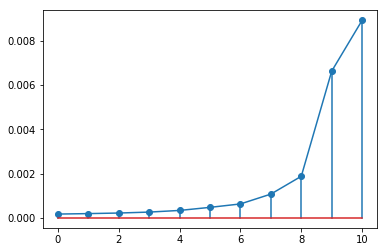

In [27]:
avgs = avgs_by_bound
plt.clf()
plt.plot(avgs)
plt.stem(avgs)
plt.show()

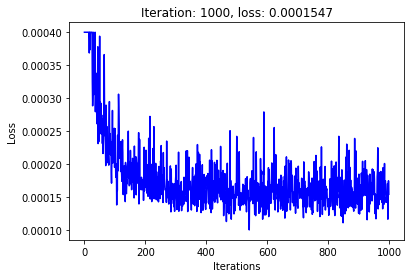

In [32]:
'''
Hyperparameter search
'''
#from IPython.display import clear_output
import time
from prettytable import PrettyTable
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

num_particles = 32 # defaults 16**3
lr = 0.01
mb_size = 8
n_epochs = 1000
chan_vals = [2**i for i in range(3,9)]
chan_depth = [i for i in range(2,15)]
channels = [list(np.random.choice(chan_vals, np.random.choice(chan_depth))) for i in range(1000)]
#bounds = [0.0, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
#redshifts = [(0.4, 0.0), (0.8, 0.0), (6.0, 1.2), (4.0, 2.0), (0.8, 0.6), (1.5, 1.0), (1.2, 0.2), (6.0, 0.4)]
#n_NN = list(np.arange(8,31))
#n_NN.insert(0,0)
#rads = [0.0095, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001]
redshifts = [(0.4, 0.0), (6.0, 0.0), (4.0, 0.6), (0.8, 0.2), (1.0, 0.4), (2.0, 0.8), (1.2, 0.6), (2.0, 1.5), (0.4, 0.2)]
search_params = channels
param_label = "chans"

#specs = [('knn', 9),('knn', 11),('knn', 13),('knn', 15),('knn', 17),('knn', 21),('knn', 23),('knn', 25),('knn', 27), ]
loss_history = np.zeros((n_epochs), dtype=np.float32)
#loss_avgs = np.zeros((len(search_params), len(redshifts)))

def get_bounded(x, bound, xp=cupy):
    #gtb, ltb = bound, 1-bound
    lower, upper = bound, 1-bound
    gt = lower < x.data
    lt = x.data < upper
    bounded = xp.all(gt & lt, axis=-1) # shape should be (mb_size, 4096)
    return bounded

def loss_funv_bounded(x_hat, x_true, bound):
    # loss part
    readout = x_hat[...,:3]
    x_true_loc = x_true[...,:3]
    bounding_idx = get_bounded(x_true_loc, bound)
    bounded_hat = F.get_item(x_hat, bounding_idx)
    #bdreadout = F.get_item(readout, bounding_idx)
    #bdreadout = F.get_item(x_hat, bounding_idx)
    bounded_true = F.get_item(x_true, bounding_idx)
    #bdx_true_loc = F.get_item(x_true_loc, bounding_idx)
    #bdx_true_loc = F.get_item(x_true, bounding_idx)
    dist_mse = F.mean(F.sum(F.square(bounded_hat[...,:3] - bounded_true[...,:3]), axis=-1))
    #dist_mse = F.mean(F.sqrt(F.sum(F.square(bounded_hat[...,:3] - bounded_true[...,:3]), axis=-1)))
    return dist_mse

seed_rng(rng_seed) # insure that every model begins with same
zX, zY = (0.4, 0.0)
_X,_Y = load_data(zX, zY, num_particles)
X,Y = np.copy(_X), np.copy(_Y)
X = normalize(X)
Y = normalize(Y)
chan = [6, 128, 32, 8, 8, 8, 256, 256, 128, 16, 16, 8, 32, 8, 3]
#chan = [6, 8, 64, 8, 64, 32, 32, 16, 3]
#chan = [6, 128, 128, 32, 32, 16, 16, 8, 8, 256, 256, 128, 128, 16, 16, 8, 8, 3]
use_graph = False
model = models.nBodyModel(chan, use_graph=use_graph)
model.to_gpu()
optimizer = optimizers.Adam(alpha=lr)
optimizer.setup(model)

seed_rng(rng_seed) # insure that every model begins with same
#cur_settings = [PARAM, rs]
#print('param: {}, zX, zY: {}'.format(PARAM, (zX,zY)))
t0 = time.time()
for epoch in range(1, n_epochs+1):
    model.zerograds()
    # data
    _x_in_, _x_true_ = next_minibatch([X,Y], mb_size)
    _x_in, _x_true = np.copy(_x_in_), np.copy(_x_true_)
    x_in = chainer.Variable(cuda.to_gpu(_x_in.astype(xp.float32)))
    x_true = chainer.Variable(cuda.to_gpu(_x_true.astype(xp.float32)))
    # forward
    if not use_graph:
        graphNN = None
    else:
        graphNN = graph_ops.GraphNN(_x_in, 'rad', PARAM)
        #assert graphNN.graph.alist.shape[-1] == PARAM
    #x_hat = model(x_in, graphNN=graphNN, add=True, bounded=True) # prediction
    x_hat = model(x_in, add=True, bounded=True) # prediction
    #loss = nn.loss_fun_bounded(x_hat, x_true, 0.095)
    loss = loss_funv_bounded(x_hat, x_true, 0.095)
    # backprop
    loss.backward()
    optimizer.update()
    loss_history[epoch-1] = cuda.to_cpu(loss.data)
    # Plot loss and save current model weights
    if epoch % 10 == 0:
        #print('{0:^4}    {1:^5}    {2:^4}'.format(epoch, loss_history[epoch-1], time.time()-t0))
        #elapsed = time.time() - t0
        #print('time: {}'.format(elapsed))
        cur = str(epoch)
        #np.save(model_dir + 'loss_history', loss_history)
        # plot loss
        plt.yscale('log')
        plt.grid(True)
        plt.clf()
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        y = loss_history[:epoch]
        yclip = .0004#np.mean(loss_history[:40])
        xvals = np.arange(epoch)
        plt.plot(xvals, np.clip(y,0,yclip), 'b-')
        #poly = np.poly1d(np.polyfit(xvals, np.clip(y,0,yclip), 4))
        #plt.plot(xvals, poly(xvals), c='orange', linewidth=2.0)
        #plt.yscale('linear')
        plt.title('Iteration: {0}, loss: {1:.4}'.format(epoch, loss_history[epoch-1]))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        #endloss = np.mean(loss_history[-250:, p_idx, rs_idx])
        #loss_avgs[p_idx, rs_idx] = endloss
        #rsf = (endloss, cur_settings)
        #clear_output(wait=True)
        #pprint_avgs(loss_avgs)
#print('time: {}'.format(time.time() - t0))

In [25]:
#loss_hist2 = loss_history
lh1 = np.median(loss_history[-50:])
lh2 = np.median(loss_hist2[-50:])
print('{} {}'.format(lh1, lh2))
# WHATS NEXT: do search over some theta that minimizes X.V*theta - X_next

0.00011218803410883993 0.00012649863492697477


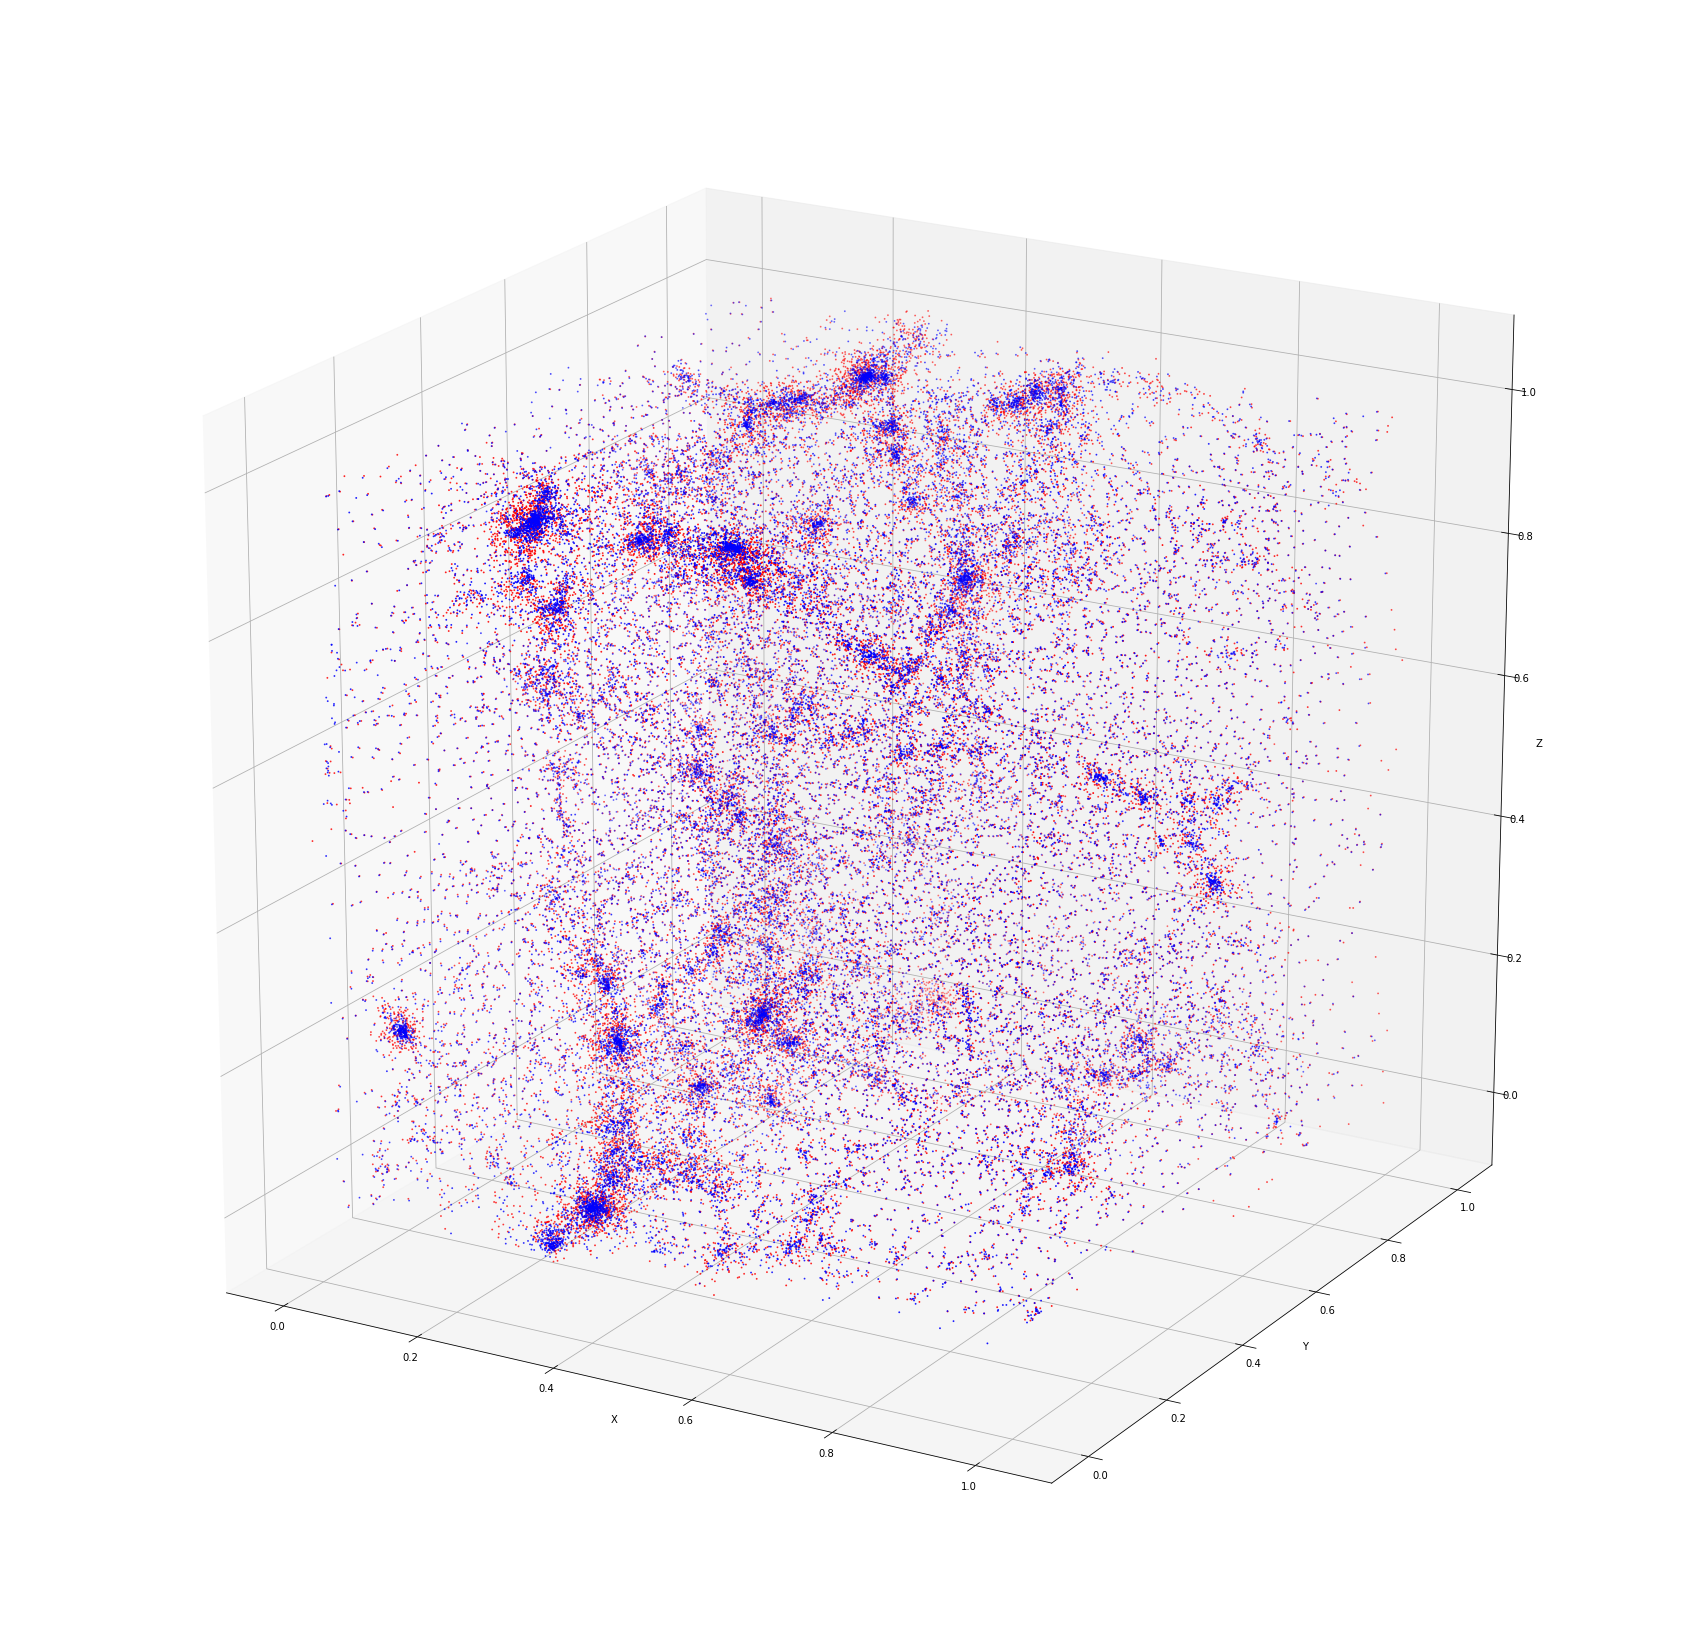

In [42]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from mpl_toolkits.mplot3d import Axes3D
#SAVE_XT = cuda.to_cpu(x_true.data)
#SAVE_XH = cuda.to_cpu(x_hat.data)
xt = cuda.to_cpu(x_true.data)
xh = cuda.to_cpu(x_hat.data)
#xt2 = xt
#xh2 = xh
xt_x = xt[:,:,0]
xt_y = xt[:,:,1]
xt_z = xt[:,:,2]

xh_x = xh[:,:,0]
xh_y = xh[:,:,1]
xh_z = xh[:,:,2]

j = 7
particle_size = .8
truth_color = 'b'
pred_color = 'r'

plt.close('all')
plt.clf()
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(xt_x[j], xt_y[j], xt_z[j], s=particle_size,c=truth_color)
ax1.scatter(xh_x[j], xh_y[j], xh_z[j], s=particle_size,c=pred_color)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(20, 300)

In [22]:
xh2diff = np.abs(xh2[...,:3] - xt2[...,:3])
xhdiff = np.abs(xh[...,:3] - xt[...,:3])
print('{}  {}'.format(np.sum(xhdiff), np.sum(xh2diff)))

1125.316162109375  1364.219970703125


In [19]:
xt2 == xt

array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ..., 
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ..., 
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ..., 
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       ..., 
   

In [52]:
d1 = np.sum(diff_sqrt, axis=(0,-1))
d2 = np.sum(diff_nosqrt, axis=(0,-1))
sqdiff_sqrt   = np.square((SAVE_XH[...,:3] - xt[...,:3]))
sqdiff_nosqrt = np.square((xh[...,:3] - xt[...,:3]))
print('{}  {}'.format(np.sum(sqdiff_sqrt), np.sum(sqdiff_nosqrt)))

1093.095947265625  1092.0498046875


array([[[  6.62505627e-04,   8.67962837e-04,   7.10394233e-05],
        [  6.07073307e-04,   9.11295414e-04,   5.23552299e-05],
        [  7.10487366e-04,   9.24766064e-04,   6.21136278e-05],
        ..., 
        [  7.34597445e-04,   1.29690766e-03,   1.90325081e-04],
        [  6.93410635e-04,   1.19283795e-03,   2.38224864e-04],
        [  7.63356686e-04,   8.92519951e-04,   1.63450837e-04]],

       [[  9.42140818e-04,   8.62479210e-05,   1.00916624e-03],
        [  4.53636050e-04,   7.78853893e-04,   3.57967615e-03],
        [  1.88517570e-03,   1.47166848e-03,   2.06571817e-03],
        ..., 
        [  2.19675899e-03,   3.02597880e-04,   9.99391079e-04],
        [  3.10054421e-03,   3.76611948e-04,   9.41157341e-04],
        [  2.01787055e-03,   9.76145267e-04,   4.98890877e-04]],

       [[  6.86019659e-04,   1.19918585e-03,   2.36183405e-05],
        [  6.30713999e-04,   1.12903118e-03,   1.51101500e-04],
        [  8.47764313e-04,   1.26052648e-03,   1.23854727e-04],
        

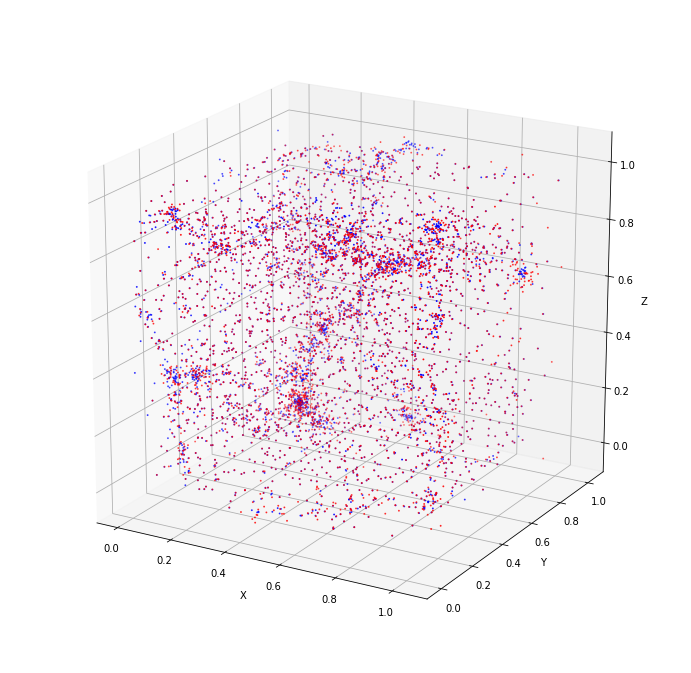

In [20]:
'''
plot
'''
from mpl_toolkits.mplot3d import Axes3D
#SAVE_XT = cuda.to_cpu(x_true.data)
#SAVE_XH = cuda.to_cpu(x_hat.data)
xt = cuda.to_cpu(x_true.data)
xh = cuda.to_cpu(x_hat.data)
xt_x = xt[:,:,0]
xt_y = xt[:,:,1]
xt_z = xt[:,:,2]

xh_x = xh[:,:,0]
xh_y = xh[:,:,1]
xh_z = xh[:,:,2]

j = 7
particle_size = .8
truth_color = 'b'
pred_color = 'r'

plt.close('all')
plt.clf()
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(xt_x[j], xt_y[j], xt_z[j], s=particle_size,c=truth_color)
ax1.scatter(xh_x[j], xh_y[j], xh_z[j], s=particle_size,c=pred_color)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(20, 300)